<a href="https://colab.research.google.com/github/YUDIPALACIOS/SistemasMultiAgentes/blob/main/Reto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 636.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/mesa/time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


Tiempo de ejecución: 0:00:00.048029


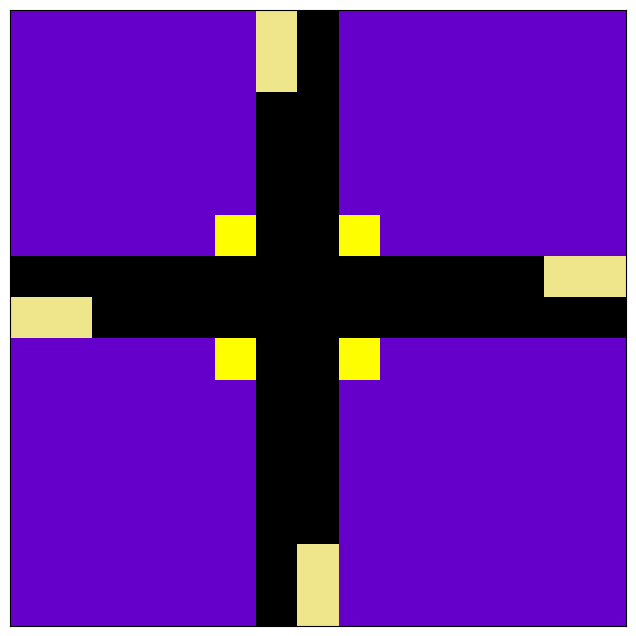

In [ ]:
from mesa.space import SingleGrid
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128
import numpy as np
import time
import datetime
import json

class Message():

    performatives = ["request","inform","vote"]
    parameters = ["content","sender","reply-with","in-reply-to"]

    def __init__(self,msg="",performative="",content="",sender="",query="q1",is_reply=True,vote=None):
        """Constructor to build a new message"""
        self.empty = False
        self.request = False
        self.inform = False
        self.vote = False
        self.msg = msg

        #If we want to build a message from the paramters
        if msg == "":
            self.is_reply = is_reply
            self.query = query
            assert performative in Message.performatives , f"Performaive: {performative}"
            self.performative=performative
            self.content = content
            self.sender = sender

        #if we want to build a message from a string (a KQML message)
        else:
            self.decode()

        #Identify if its either Request or Inform performative
        if self.performative == "request":
            self.request = True
        elif self.performative == "inform":
            self.inform = True
        elif self.performative == "vote":
            self.vote = True
        else:
            self.empty = True

    def decode(self):
        """Method to convert a string message (KQML format) to message parameters"""
        current = self.msg[1:-1]
        current = current.split("\n")
        self.performative = current[0]
        assert self.performative in Message.performatives , f"Performaive: {self.performative}"
        parameterList = current[1].split(":")[1:]
        parametersDict = {}
        for parameter in parameterList:
            pair = parameter.split(" ")
            parametersDict[pair[0]] = pair[1]
        if "in-reply-to" in parametersDict.keys():
            self.query = parametersDict["in-reply-to"]
            self.is_reply = True
        else:
            self.query = parametersDict["reply-with"]
            self.is_reply = False
        self.content = parametersDict["content"]
        self.sender = parametersDict["sender"]

    def __str__(self):
        """Method to convert message paramters to a string (KQML format)"""
        s = "("
        s+= self.performative + "\n"
        s+= ":sender " + self.sender
        s+= ":content "+self.content
        if self.is_reply:
            s+= ":in-reply-to " + self.query
        else:
            s+= ":reply-with " + self.query
        s+= ")"
        return s


class terrainAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

class trafficLightAgent(Agent):
    def __init__(self, unique_id, model, is_vertical):
        super().__init__(unique_id, model)
        self.colour = "yellow"
        self.vertical = is_vertical
        self.turn = False
    def request_votes(self):
        for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False):
            if isinstance(neighbor, terrainAgent):
                msg = Message(performative="request", content="Please vote for green light duration", sender=str(self.unique_id))
                self.model.grid.get_cell_list_contents([neighbor.pos])[0].msg = msg

    def count_votes(self):
        votes = {"short": 0, "medium": 0, "long": 0}
        for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False):
            if isinstance(neighbor, terrainAgent):
                if neighbor.msg and neighbor.msg.performative == "vote":
                    votes[neighbor.msg.content] += 1
        return max(votes, key=votes.get)  # Devuelve la duración más votada

    def rules(self):
        self.request_votes()
        green_duration = self.count_votes()
        if green_duration == "short":
           self.colour = "green"
        elif green_duration == "medium":
            self.colour = "green"
        elif green_duration == "long":
            self.colour = "green"
        else:
            self.colour = "yellow"  # ¿Qué color debería ser si no hay una duración más votada?
        # Aquí se tomaría la acción adecuada basada en la duración de la luz verde

    def step(self):
        self.rules()
        if self.colour == "green":
            nearby_cars = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False, radius=1)
            for car in nearby_cars:
                if isinstance(car, carAgent):
                    self.model.broadcastMessage = Message(performative="inform", content="Green Light", sender= "id: " + str(self.unique_id))


    def checkGreenLights(self, array):
        for lights in array:
            if lights.colour == "green":
                return True
        return False

class carAgent(Agent):
    def __init__(self, unique_id, model, probability_of_turning, dx, dy):
        super().__init__(unique_id, model)
        self.dx = dx
        self.dy = dy
        self.light = False
        self.probability_of_turning = probability_of_turning
        self.laps = 0

        if self.dy == 0:
            self.vertical = True
        else:
            self.vertical = False


    def move(self):
        posX, posY = self.pos
        next_pos = (posX + self.dx, posY + self.dy)

        if self.model.grid.out_of_bounds(next_pos):
            self.next_pos = self.model.grid.torus_adj(next_pos)
            self.laps += 1
            self.light = False
        else:
            self.next_pos = next_pos

        checkPosX, checkPosY = self.pos
        if self.vertical:
            checkPosY -= self.dx
        else:
            checkPosX += self.dy

        checkPos = (checkPosX, checkPosY)

        traffic_light_Cell = self.model.grid.get_cell_list_contents([checkPos])


        if not self.model.grid.is_cell_empty(checkPos) and isinstance(traffic_light_Cell[0], trafficLightAgent) and not self.light:
            if traffic_light_Cell[0].colour == "green" and self.model.grid.is_cell_empty(self.next_pos):
                self.receive_message()
                self.model.grid.move_agent(self, self.next_pos)
        else:
            if self.model.grid.is_cell_empty(self.next_pos):
                self.model.grid.move_agent(self, self.next_pos)

    def turn(self):
        posX, posY = self.pos

        half_model_width = int(self.model.width/2)
        half_model_height = int(self.model.height/2)

        if self.vertical:

            if posX == half_model_width - 1 and posY == half_model_height - 1:
                self.change_direction(0, -1)
            elif posX == half_model_width - 1 and posY == half_model_height:
                self.change_direction(0, -1)

            elif posX == half_model_width and posY == half_model_height - 1:
                self.change_direction(0, 1)
            elif posX == half_model_width and posY == half_model_height:
                self.change_direction(0, 1)
        else:

            if posX == half_model_width - 1 and posY == half_model_height - 1:
                self.change_direction(1, 0)
            elif posX == half_model_width - 1 and posY == half_model_height:
                self.change_direction(-1, 0)


            elif posX == half_model_width and posY == half_model_height - 1:
                self.change_direction(1, 0)
            elif posX == half_model_width and posY == half_model_height:
                self.change_direction(-1, 0)

    def change_direction(self, dx, dy):
        self.dx = dx
        self.dy = dy

        if self.dy == 0:
            self.vertical = True
        else:
            self.vertical = False


    def receive_message(self):
        self.msg = self.model.broadcastMessage
        if self.msg.performative == "inform" and self.msg.content == "Green Light":
            self.light = True
            # Coordinar movimiento con semáforo en verde
            self.move()

    def step(self):

        neighbors = self.model.grid.iter_neighbors(
            self.pos,
            moore=False,
            include_center=False)

        neighbor_counter = 0

        for neighbor in neighbors:
            if not isinstance(neighbor, carAgent):
                neighbor_counter += 1

        if self.probability_of_turning >= np.random.random() and neighbor_counter == 0:
            self.turn()

        self.move()

class streetModel(Model):
    def __init__(self, width=11, height=11, car_agents=4, probability_of_turning=0):
        super().__init__()
        self.grid = SingleGrid(width, height, True)
        self.width = width
        self.height = height
        self.schedule = RandomActivation(self)
        self.broadcastMessage = ""

        t1 = trafficLightAgent(car_agents, self, True)
        self.grid.place_agent(
            t1,
            (int(width/2) - 2, int(height/2) - 2)
        )
        self.schedule.add(t1)

        t2 = trafficLightAgent(car_agents + 1, self, False)
        self.grid.place_agent(
            t2,
            (int(width/2) - 2, int(height/2) + 1)
        )
        self.schedule.add(t2)

        t3 = trafficLightAgent(car_agents + 2, self, False)
        self.grid.place_agent(
            t3,
            (int(width/2) + 1, int(height/2) - 2)
        )
        self.schedule.add(t3)

        t4 = trafficLightAgent(car_agents + 3, self, True)
        self.grid.place_agent(
            t4,
            (int(width/2) + 1, int(height/2) + 1)
        )
        self.schedule.add(t4)

        for (content, (x, y)) in self.grid.coord_iter():
            if not (x == int(width/2) or x == int(width/2) - 1 or y == int(height/2) or y == int(height/2) - 1) and content == None:
                a = terrainAgent((x, y), self)
                self.grid.place_agent(a, (x, y))

        offset = -1
        for i in range(car_agents):
            lane = i % 4

            if lane == 0:
                offset += 1
                c = carAgent(i, self, probability_of_turning, 0, 1)
                self.grid.place_agent(c, (int(height/2), offset))
            elif lane == 1:
                c = carAgent(i, self, probability_of_turning, 1, 0)
                self.grid.place_agent(c, (offset, int(width/2) - 1))
            elif lane == 2:
                c = carAgent(i, self, probability_of_turning, 0, -1)
                self.grid.place_agent(
                    c, (int(height/2) - 1, width - 1 - offset))
            elif lane == 3:
                c = carAgent(i, self, probability_of_turning, -1, 0)
                self.grid.place_agent(c, (height - 1 - offset, int(width/2)))
            self.schedule.add(c)

        self.datacollector = DataCollector(
            model_reporters={
                "Grid": self.get_grid,
            },
            agent_reporters={
                "Cars": lambda a: {"dx": a.dx, "dy": a.dy, "id": a.unique_id, "laps": a.laps} if isinstance(a, carAgent) else 0,
                "TraficLights": lambda a: {"colour": a.colour, "id": a.unique_id} if isinstance(a, trafficLightAgent) else 0,
            }
        )


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


    def get_grid(self):
        grid = np.zeros((self.grid.width, self.grid.height))
        for tile in self.grid.coord_iter():
            tile_content, (x, y) = tile
            if isinstance(tile_content, terrainAgent):
                grid[x][y] = 0

            elif isinstance(tile_content, trafficLightAgent):
                if tile_content.colour == "yellow":
                    grid[x][y] = 1
                elif tile_content.colour == "green":
                    grid[x][y] = 2
                else:
                    grid[x][y] = 3

            elif isinstance(tile_content, carAgent):
                grid[x][y] = 4

            else:
                grid[x][y] = 5

        return grid

GRID_WIDTH = 15

GRID_HEIGHT = 15

CAR_AGENTS = 8

NUM_GENERATIONS = 100

PROBABILITY_OF_TURNING = 0.05

MAX_TIME = 0.010

start_time = time.time()
model = streetModel(GRID_WIDTH, GRID_HEIGHT, CAR_AGENTS, PROBABILITY_OF_TURNING)

for i in range(NUM_GENERATIONS):
        model.step()

print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

carsDf = model.datacollector.get_agent_vars_dataframe().loc[:, ["Cars"]]

trafficLightsDf = model.datacollector.get_agent_vars_dataframe().loc[:, ["TraficLights"]]

steps = []

cars = [None] * CAR_AGENTS

prevIndex = 0

for index, row in carsDf.iterrows():

    if (row.Cars == 0):
        continue

    if prevIndex == index[0]:
        cars[row.Cars["id"] - 1] = row.Cars
    else:
        prevIndex = index[0]
        steps.append({"cars": cars,  "traficLights": []})
        cars = [None] * CAR_AGENTS
        cars[row.Cars["id"] - 1] = row.Cars

steps.append({"cars": cars, "traficLights": []})

for index, row in trafficLightsDf.iterrows():
    if (row.TraficLights == 0):
        continue

    steps[index[0]]["traficLights"].append(row.TraficLights)


with open('steps-data.json', 'w') as outfile:
    json.dump({"modelData": {"width": GRID_WIDTH, "height": GRID_HEIGHT,
              "carAgents": CAR_AGENTS, "numGenerations": NUM_GENERATIONS}, "steps": steps}, outfile)

all_grid = model.datacollector.get_model_vars_dataframe().loc[:, ["Grid"]]

fig, axs = plt.subplots(figsize=(8,8))
axs.set_xticks([])
axs.set_yticks([])
cmap = matplotlib.colormaps['viridis']
cmap = cmap(np.linspace(0, 1, 6))
cmap[0] = np.array([102 / 256, 0, 204 / 256, 1])
cmap[1] = np.array([255/256, 255/256, 0/256, 1])
cmap[2] = np.array([0/256, 256/256, 0/256, 1])
cmap[3] = np.array([255/256, 0/256, 0/256, 1])
cmap[4] = np.array([240 / 256, 230 / 256, 140 / 256, 1])
cmap[5] = np.array([0, 0, 0, 1])

new_cmap = matplotlib.colors.ListedColormap(cmap)
patch = plt.imshow(all_grid.iloc[0][0], cmap=new_cmap)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

anim

In [ ]:
!pip install mesa